# MNIST with custom framework

In [1]:
from centigrad.nn import Module, Linear, ReLU, Softmax
from centigrad.losses import CrossEntropyLoss
import numpy as np
import matplotlib.pyplot as plt

## Load MNIST dataset

In [2]:
import tensorflow as tf
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

In [3]:
x_train = np.array((train_x / 255), dtype=np.float32).reshape(train_x.shape[0], -1)
x_test = np.array((test_x / 255), dtype=np.float32).reshape(test_x.shape[0], -1)
y_train = np.array(np.eye(10)[train_y], dtype=np.float32)
y_test = np.array(np.eye(10)[test_y], dtype=np.float32)

## Define the model

In [4]:
class NN(Module):
    def __init__(self):
        self.l1 = Linear(784, 16, low=-1.0)
        self.a1 = ReLU()
        self.l2 = Linear(16, 10, low=-1.0)
        self.a2 = Softmax()
    def forward(self, inputs: np.ndarray):
        out = self.l1.forward(inputs)
        out = self.a1.forward(out)
        out = self.l2.forward(out)
        out = self.a2.forward(out)
        return out
    def parameters(self):
        params = []
        params.extend(self.l1.parameters())
        params.extend(self.l2.parameters())
        return params
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0
    def update(self, lr=0.01):
        for p in self.parameters():
            p.data += -lr * p.grad

In [5]:
model = NN()
loss_function = CrossEntropyLoss()
batch_size = 32
losses, accuracies = [], []

## Training

#### Create and resize sample batch

In [6]:
sample_indices = np.random.randint(0, x_train.shape[0], size=batch_size)
print("input indexes: ", sample_indices)
xs = x_train[sample_indices]
print("input shape: ", xs.shape)

input indexes:  [39219  1794 58972 28548  1977 40329 54436  1753 19598 30548 42916 44581
  8894 13247 49575 54351  9946 50306  2827 58611 43971 14476  9320 29591
 44698 39697 50000 29356 32157 29043 47746 32654]
input shape:  (32, 784)


In [7]:
ys = y_train[sample_indices]
print("targets[0]: ", ys[0])
print("output shape: ", ys.shape)

targets[0]:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
output shape:  (32, 10)


### Forward

In [8]:
out = np.array([model.forward(x) for x in xs])
print("output shape: ", out.shape)
print("output[0]: ", out[0])

output shape:  (32, 10)
output[0]:  [Value(data=5.424667192801418e-09, grad=0.0)
 Value(data=3.728810295013344e-14, grad=0.0)
 Value(data=5.4364193063261604e-08, grad=0.0)
 Value(data=0.00014534874372139025, grad=0.0)
 Value(data=8.73702056632815e-05, grad=0.0)
 Value(data=2.7883717888383848e-08, grad=0.0)
 Value(data=0.9888782556274807, grad=0.0)
 Value(data=0.0013258795681526292, grad=0.0)
 Value(data=0.009558229513778556, grad=0.0)
 Value(data=4.828668588084224e-06, grad=0.0)]


In [9]:
ys[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [10]:
loss = loss_function.forward(out, ys)
losses.append(loss.data)
print(loss)

Value(data=8.733844005309978, grad=0.0)


### Backward

In [11]:
model.zero_grad()
loss.backward()

### Update

In [12]:
model.update(lr=0.1)

In [13]:
for k in range(10):
    # create batch
    sample_indices = np.random.randint(0, x_train.shape[0], size=batch_size)
    xs = x_train[sample_indices].reshape(x_train[sample_indices].shape[0], -1)
    ys = y_train[sample_indices]
    # forward
    out = np.array([model.forward(x) for x in xs])
    loss = loss_function.forward(out, ys)
    losses.append(loss.data)
    accuracy = np.sum([np.argmax(out[i]) == np.argmax(ys[i]) for i in range(out.shape[0])]) / out.shape[0]
    accuracies.append(accuracy)
    # backward
    model.zero_grad()
    loss.backward()
    model.update(lr=0.1)
    print(f"step {k} loss {loss.data}, accuracy {accuracy*100}%")

step 0 loss 5.504431370327378, accuracy 9.375%
step 1 loss 6.220878462825519, accuracy 6.25%
step 2 loss 4.422930153546918, accuracy 31.25%
step 3 loss 5.539997168860207, accuracy 12.5%
step 4 loss 5.63442482263122, accuracy 12.5%
step 5 loss 3.7729762534945257, accuracy 18.75%
step 6 loss 4.887366975996981, accuracy 21.875%
step 7 loss 4.074915043415187, accuracy 9.375%
step 8 loss 2.5827584269970227, accuracy 12.5%
step 9 loss 3.3734950992300705, accuracy 12.5%


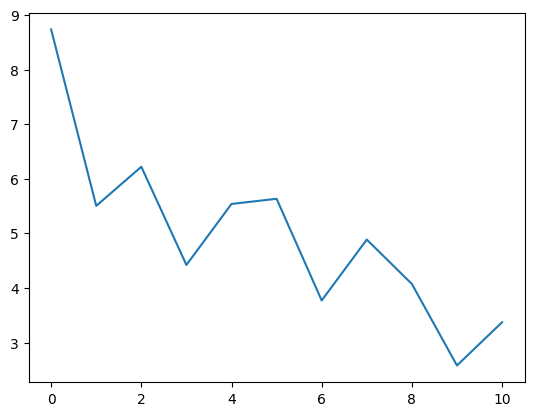

In [14]:
plt.plot(losses)